# ORICORE 2024 (Sept) II -- new orientation convolution for MBET datasets

In [1]:
GPU = 0

import sys
import os
import torch
#from torch import nn

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)
sys.path.insert(0, '/home/dbutts/Code/') 
if myhost=='m1':
    datadir = '/home/dbutts/V1/B2data/'
    dirname = '/home/dbutts/V1/Binocular/Bworkspace/' # Working directory 
elif myhost=='ca3':
    datadir = '/home/DATA/ColorV1/'
    dirname = '/home/dbutts/ColorV1/CLRworkspace/'
    print('cuda0:', torch.cuda.get_device_properties(0).name)
    print('cuda1:', torch.cuda.get_device_properties(1).name)
    GPU = abs((torch.cuda.get_device_properties(0).minor == 9) - (GPU==0))
else:  # older computers: M1, MT
    datadir = '/home/dbutts/V1/Binocular/Data/'
    dirname = '/home/dbutts/V1/Binocular/Bworkspace/' # Working directory

import numpy as np
import scipy.io as sio
from copy import deepcopy
from scipy import ndimage
from time import time
import h5py 
import dill

# plotting
import matplotlib.pyplot as plt

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDN as NDN
from NDNT.modules.layers import *
from NDNT.networks import *

from NTdatasets.generic import GenericDataset
import NTdatasets.conway.multi_datasets as multidata

import ColorDataUtils.ConwayUtils as CU
from ColorDataUtils.DDPIutils import DDPIutils
import ColorDataUtils.EyeTrackingUtils as ETutils
from ColorDataUtils.sync_clocks import convertSamplesToTimestamps, alignTimestampToTimestamp

from ColorDataUtils import readout_fit
# Useful utility functions
from NDNT.utils import fit_lbfgs
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

device0 = torch.device("cpu")
if GPU == 0:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # then ada = cuda:0
else:
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print('Assigned:', device)      

%load_ext autoreload
%autoreload 2

Running on Computer: [ca3]
cuda0: NVIDIA RTX 6000 Ada Generation
cuda1: NVIDIA RTX A6000
Invoking __init__.py for NDNT.utils
Assigned: cuda:0


In [2]:
num_lags=16
ETthresh=0.9
expt_names = ['J220707', 'J220715','J220722', 'J220801']  #
#expt_names = ['J220715','J220722','J220808']
#expt_names=['J220715']
from ColorDataUtils.multidata_utils import MultiExperiment
expts = MultiExperiment(names=expt_names,
                        datadir=datadir,
                        num_lags=num_lags,
                        et_metric_thresh=ETthresh,
                        array_types='UT',
                        luminance_only=True)
data = expts.build_stim()
NC = data.NC
NA = data.Xdrift.shape[1]

  FILE_INFO: stim_locsLP list again -- ok but output check
  Disjoint data exists with this eye_config -- trunctating to first section.
  FILE_INFO: stim_locsLP list again -- ok but output check
  FILE_INFO: stim_locsLP list again -- ok but output check
  Disjoint data exists with this eye_config -- trunctating to first section.
  FILE_INFO: stim_locsLP list again -- ok but output check
  MULTIDATASET 4 expts: 598080 total time steps, 598 units
  Expt #0: 75.0 percent of data remaining.
  Expt #1: 76.4 percent of data remaining.
  Expt #2: 74.8 percent of data remaining.
  Expt #3: 75.1 percent of data remaining.
  Stim expansion for shift: [905, 495, 1005, 595]
  Writing lam stim 0: overlap 60, 60
  Writing ETstim 0: overlap 41, 60
  Writing ETstim 1: overlap 60, 26
  Adding fixation point
  Shifting stim...


100%|███████████████████████████████████████████████████████| 28/28 [00:06<00:00,  4.09it/s]


  CROP: New stim size: 60 x 60
  Done: expt 0
  Stim expansion for shift: [900, 492, 1000, 592]
  Writing lam stim 0: overlap 60, 47
  Writing lam stim 1: overlap 60, 53
  Writing lam stim 2: overlap 33, 53
  Writing lam stim 3: overlap 33, 47
  Writing ETstim 0: overlap 7, 53
  Writing ETstim 1: overlap 7, 47
  Adding fixation point
  Shifting stim...


100%|███████████████████████████████████████████████████████| 34/34 [00:08<00:00,  4.17it/s]


  CROP: New stim size: 60 x 60
  Done: expt 1
  Stim expansion for shift: [906, 491, 1006, 591]
  Writing lam stim 0: overlap 60, 49
  Writing lam stim 1: overlap 60, 51
  Writing lam stim 2: overlap 32, 51
  Writing lam stim 3: overlap 32, 49
  Writing ETstim 0: overlap 11, 51
  Writing ETstim 1: overlap 11, 48
  Adding fixation point
  Shifting stim...


100%|███████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.90it/s]


  CROP: New stim size: 60 x 60
  Done: expt 2
  Stim expansion for shift: [906, 491, 1006, 591]
  Writing lam stim 0: overlap 60, 52
  Writing lam stim 1: overlap 60, 48
  Writing lam stim 2: overlap 30, 48
  Writing lam stim 3: overlap 30, 52
  Writing ETstim 0: overlap 9, 48
  Writing ETstim 1: overlap 9, 50
  Adding fixation point
  Shifting stim...


100%|███████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.12it/s]


  CROP: New stim size: 60 x 60
  Done: expt 3
Stimulus assembly complete


In [4]:
cnn0 = NDN.load_model_zip(dirname+'cnn0standard.ndn')

thetadata = utils.load_python_data( dirname + 'core_thetas.py')
cells = thetadata['cells']
thetas = thetadata['thetas']
osis = thetadata['osis']

# Choose a threshold and subsample each experiment based on valUT, and 
thresh = 0.08
cselect = [[]]*4  ### this is the numbering of the cells above threshold within each experiment
cselect_abs = [[]]*4 ## this is based on indexing total cells, versus valUT alone
NCsC = np.zeros(4, dtype=int)
cselect_index = []  # overall index across 4 experiment for valid cells (for translating drift_terms and mus)
val_count = 0
for ee in range(4):
    cselect[ee] = np.where(osis[ee] > thresh)[0].astype(int)
    cselect_abs[ee] = data.cranges[ee][cselect[ee]].astype(int)
    NCsC[ee] = len(cselect[ee])
    cselect_index = np.concatenate( (cselect_index, val_count+cselect[ee]), axis=0 ).astype(int)
    val_count += data.exptNC[ee]
NCC = np.sum(NCsC)
print(NCsC, NCC)

adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=12, num_workers=0,  # Double batch size (was 4)
    learning_rate=0.01, early_stopping_patience=4,  # changed from 4
    optimize_graph=False, weight_decay = 0.2)
adam_pars['device'] = device
adam_pars['accumulated_grad_batches'] = 5 # Double again

Loaded data from /home/dbutts/ColorV1/CLRworkspace/core_thetas.py
[36 34 14 18] 102


In [3]:
exptsC = MultiExperiment(names=expt_names,
                        datadir=datadir,
                        num_lags=num_lags,
                        et_metric_thresh=ETthresh,
                        array_types='UT',
                        luminance_only=True)
dataC = exptsC.build_stim()

  FILE_INFO: stim_locsLP list again -- ok but output check
  Disjoint data exists with this eye_config -- trunctating to first section.
  FILE_INFO: stim_locsLP list again -- ok but output check
  FILE_INFO: stim_locsLP list again -- ok but output check
  Disjoint data exists with this eye_config -- trunctating to first section.
  FILE_INFO: stim_locsLP list again -- ok but output check
  MULTIDATASET 4 expts: 598080 total time steps, 598 units
  Expt #0: 75.0 percent of data remaining.
  Expt #1: 76.4 percent of data remaining.
  Expt #2: 74.8 percent of data remaining.
  Expt #3: 75.1 percent of data remaining.
  Stim expansion for shift: [905, 495, 1005, 595]
  Writing lam stim 0: overlap 60, 60
  Writing ETstim 0: overlap 41, 60
  Writing ETstim 1: overlap 60, 26
  Adding fixation point
  Shifting stim...


100%|███████████████████████████████████████████████████████| 28/28 [00:07<00:00,  3.69it/s]


  CROP: New stim size: 60 x 60
  Done: expt 0
  Stim expansion for shift: [900, 492, 1000, 592]
  Writing lam stim 0: overlap 60, 47
  Writing lam stim 1: overlap 60, 53
  Writing lam stim 2: overlap 33, 53
  Writing lam stim 3: overlap 33, 47
  Writing ETstim 0: overlap 7, 53
  Writing ETstim 1: overlap 7, 47
  Adding fixation point
  Shifting stim...


100%|███████████████████████████████████████████████████████| 34/34 [00:08<00:00,  3.80it/s]


  CROP: New stim size: 60 x 60
  Done: expt 1
  Stim expansion for shift: [906, 491, 1006, 591]
  Writing lam stim 0: overlap 60, 49
  Writing lam stim 1: overlap 60, 51
  Writing lam stim 2: overlap 32, 51
  Writing lam stim 3: overlap 32, 49
  Writing ETstim 0: overlap 11, 51
  Writing ETstim 1: overlap 11, 48
  Adding fixation point
  Shifting stim...


100%|███████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.47it/s]


  CROP: New stim size: 60 x 60
  Done: expt 2
  Stim expansion for shift: [906, 491, 1006, 591]
  Writing lam stim 0: overlap 60, 52
  Writing lam stim 1: overlap 60, 48
  Writing lam stim 2: overlap 30, 48
  Writing lam stim 3: overlap 30, 52
  Writing ETstim 0: overlap 9, 48
  Writing ETstim 1: overlap 9, 50
  Adding fixation point
  Shifting stim...


100%|███████████████████████████████████████████████████████| 36/36 [00:09<00:00,  3.84it/s]


  CROP: New stim size: 60 x 60
  Done: expt 3
Stimulus assembly complete


In [5]:
# Recast dataset with select cells
dataC.modify_included_cells(cselect_abs)
print(dataC.NC, np.sum(dataC.exptNC), NCC)
for ee in range(data.Nexpts):
    dataC.restrict2good_fixations( expts.experiments[ee].metric[:,1], expt_n=ee, thresh=ETthresh)

102 102 102
  Expt #0: 75.0 percent of data remaining.
  Expt #1: 76.4 percent of data remaining.
  Expt #2: 74.8 percent of data remaining.
  Expt #3: 75.1 percent of data remaining.


In [6]:
# Assemble data for the 102 cells
drift_termsC = expts.drift_terms[:, cselect_index]
musC = expts.mu0s[cselect_index, :]
osisC = np.zeros(NCC)
thetasC = np.zeros(NCC)
ccount = 0
for ee in range(4):
    osisC[ccount+np.arange(dataC.exptNC[ee])] = osis[ee][cselect[ee].astype(int)]
    thetasC[ccount+np.arange(dataC.exptNC[ee])] = thetas[ee][cselect[ee].astype(int)]
    ccount += dataC.exptNC[ee]

In [7]:
LLsNULL = np.zeros(dataC.NC)
Dreg = 0.1
drift_pars1N = NDNLayer.layer_dict( 
    input_dims=[1,1,1,NA], num_filters=1, bias=False, norm_type=0, NLtype='softplus',
    reg_vals = {'d2t': Dreg, 'bcs':{'d2t':0} } )
drift_mod = NDN( layer_list=[drift_pars1N], loss_type='poisson')
drift_mod.block_sample = True
drift_mod.networks[0].xstim_n = 'Xdrift'
for cc in range(dataC.NC):
    dataC.set_cells(cc)
    drift_mod.networks[0].layers[0].weight.data[:,0] = torch.tensor(drift_termsC[:,cc], dtype=torch.float32)
    LLsNULL[cc] = drift_mod.eval_models( dataC[dataC.val_blks], device=device ) 
dataC.set_cells()

## Begin: FIXED angle ORICONV with no E/I 

In [9]:
adam_parsC = deepcopy(adam_pars)
adam_parsC['accumulated_grad_batches'] = 5
adam_parsC['batch_size'] = 12
adam_parsC['weight_decay'] = 0.05

adam_2epochs = deepcopy(adam_pars)
adam_2epochs['max_epochs'] = 2

dataC.set_cells()

In [18]:
nlags=10
XTreg = 0.0001
Mreg = 0.0001
Creg = None
#Dreg = 0.5

angle_max = 180 #360  # note will wrap around to zero at this point... maybe bad for fitting
angle_inc = 30
angle_mode = 'nearest' # 'bilinear'
pos_con_internal = False
pos_con_out = False

## CORE-SCAFFOLD
num_subs = [4, 12, 8]
fws = [9, 21, 5]  
angles = np.arange(0, angle_max, angle_inc).astype(int)

# LGN layer
clayersQ = [STconvLayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=num_subs[0], norm_type=1,
    filter_dims=[1,fws[0],fws[0],nlags] , bias=False, NLtype='relu',
    padding='circular', output_norm='batch', window='hamming', initialize_center=True,
    reg_vals={'d2xt':XTreg, 'center': Creg} )]

# PROJECTION LAYER
clayersQ.append(
    OriConvLayer.layer_dict(
        num_filters=num_subs[1], num_inh=num_subs[1]//3,
        filter_width=fws[1], NLtype='relu', norm_type=1, pos_constraint=False,
        bias=False, output_norm='batch', window='hamming', padding='circular', initialize_center = True, 
        angles = angles) )

for ii in range(2,len(fws)):
    clayersQ.append(OriConvLayer.layer_dict( 
        num_filters=num_subs[ii], num_inh=num_subs[ii]//4, bias=False, norm_type=1, 
        filter_width=fws[ii], NLtype='relu', pos_constraints=pos_con_internal,
        output_norm='batch', initialize_center=True, #window='hamming', 
        angles=angles) )
        
scaffold_netQ =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold3d', xstim_n='stim', layer_list=clayersQ, scaffold_levels=[1,2], num_lags_out=len(angles))

readout_parsQ = ReadoutLayerQsample.layer_dict(
    num_filters=NCC, NLtype='softplus', bias=True, pos_constraint=pos_con_out)

readout_netQ = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0], layer_list = [readout_parsQ], ffnet_type='readout')

NQ = len(angles)
print(NQ, angles)

drift_pars = NDNLayer.layer_dict( 
    input_dims=[1,1,1,NA], num_filters=NCC, bias=False, norm_type=0, NLtype='lin')
drift_pars['reg_vals'] = {'d2t': Dreg } 

drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars] )

comb_layer = ChannelLayer.layer_dict(
    num_filters = NCC, NLtype='softplus', bias=True)
comb_layer['weights_initializer'] = 'ones'

comb_net = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[1,2],
    layer_list = [comb_layer], ffnet_type='add')


cnnC0 = NDN( 
    ffnet_list = [scaffold_netQ, readout_netQ, drift_net, comb_net], loss_type='poisson')
cnnC0.block_sample = True

## Network 0
cnnC0.networks[0].layers[0] = deepcopy(cnn0.networks[0].layers[0])
cnnC0.networks[0].layers[0].set_parameters(val=False)

## Network 1: readout: fixed mus / sigmas
#cnn0.networks[1].layers[0].sample = False
cnnC0.networks[1].layers[0].mu.data = torch.tensor( musC, dtype=torch.float32)
cnnC0.networks[1].layers[0].Qmu.data[:,0] = torch.tensor( (thetasC-90)/90, dtype=torch.float32)
cnnC0.networks[1].layers[0].fit_mus(False)
cnnC0.networks[1].layers[0].fit_Qmus(False)
cnnC0.networks[1].layers[0].Qsample_mode = angle_mode

## Network 2: drift: not fit
cnnC0.networks[2].layers[0].weight.data = torch.tensor(drift_termsC, dtype=torch.float32)
cnnC0.networks[2].set_parameters(val=False)

## Network 3: Comb
cnnC0.networks[3].set_parameters(val=False, name='weight')

cnnC0.list_parameters()

6 [  0  30  60  90 120 150]
  ReadoutLayer: not fitting mus
  ReadoutLayer: not fitting Qmus
Network 0:
  Layer 0:
      NOT FIT: weight: torch.Size([810, 4])
  Layer 1:
      weight: torch.Size([1764, 12])
  Layer 2:
      weight: torch.Size([300, 8])
Network 1:
  Layer 0:
      weight: torch.Size([20, 102])
      bias: torch.Size([102])
      NOT FIT: mu: torch.Size([102, 2])
      NOT FIT: sigma: torch.Size([102, 1])
      NOT FIT: Qmu: torch.Size([102, 1])
      NOT FIT: Qsigma: torch.Size([102, 1])
Network 2:
  Layer 0:
      NOT FIT: weight: torch.Size([158, 102])
Network 3:
  Layer 0:
      NOT FIT: weight: torch.Size([1, 102])
      bias: torch.Size([102])


In [20]:
cnnC0.fit(dataC, **adam_pars, verbose=2)
LLsC0 = LLsNULL - cnnC0.eval_models(dataC, data_inds=dataC.val_blks, batch_size=5, device=device)
print(np.mean(LLsC0))

Model: M102_CsXX_X_N_A

GPU Available: True, GPU Used: True


Validating ver=67: 100%|██████████████████| 34/34 [00:15<00:00,  2.25it/s, val_loss=0.10685]


Early stopping
Done fitting
  Fit complete: 2185.317951440811 sec elapsed


Eval models: 100%|██████████████████████████████████████████| 80/80 [00:15<00:00,  5.28it/s]

0.03454399225758571


In [21]:
cnnC0b = deepcopy(cnnC0)
cnnC0b.networks[1].layers[0].fit_Qmus(True)
cnnC0b.networks[1].layers[0].Qsample_mode = 'bilinear'
cnnC0b.list_parameters()
cnnC0b.fit(dataC, **adam_parsC, verbose=2)
LLsC0b = LLsNULL - cnnC0b.eval_models(dataC, data_inds=dataC.val_blks, batch_size=8, device=device)
print(np.mean(LLsC0), np.mean(LLsC0b))

  ReadoutLayer: fitting Qmus
Network 0:
  Layer 0:
      NOT FIT: weight: torch.Size([810, 4])
  Layer 1:
      weight: torch.Size([1764, 12])
  Layer 2:
      weight: torch.Size([300, 8])
Network 1:
  Layer 0:
      weight: torch.Size([20, 102])
      bias: torch.Size([102])
      NOT FIT: mu: torch.Size([102, 2])
      NOT FIT: sigma: torch.Size([102, 1])
      Qmu: torch.Size([102, 1])
      Qsigma: torch.Size([102, 1])
Network 2:
  Layer 0:
      NOT FIT: weight: torch.Size([158, 102])
Network 3:
  Layer 0:
      NOT FIT: weight: torch.Size([1, 102])
      bias: torch.Size([102])
Model: M102_CsXX_X_N_A

GPU Available: True, GPU Used: True


Validating ver=68: 100%|█████████████████| 34/34 [00:15<00:00,  2.26it/s, val_loss=0.106071]


Early stopping
Done fitting
  Fit complete: 2189.6420538425446 sec elapsed


Eval models: 100%|██████████████████████████████████████████| 50/50 [00:15<00:00,  3.30it/s]

0.03454399225758571 0.041113053466759475


In [22]:
cnnC1 = deepcopy(cnnC0b)
cnnC1.networks[1].layers[0].Qsample_mode = 'nearest'
cnnC1.fit(dataC, **adam_parsC, verbose=2)
LLsC1 = LLsNULL - cnnC1.eval_models(dataC, data_inds=dataC.val_blks, batch_size=8, device=device)
print(np.mean(LLsC0b), np.mean(LLsC1))

Model: M102_CsXX_X_N_A

GPU Available: True, GPU Used: True


Epoch 9:  98%|██████████████████████▍| 130/133 [04:53<00:06,  2.24s/it, train_loss=0.113436]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
print(np.mean(LLsC0b), np.mean(LLsC1))

0.041113053466759475 0.041312351530673454


In [30]:
## THIS IS JUST 3-layer model...
# regularization in projection layer?
nlags=10
XTreg = 0.0001
Mreg = 0.0001
Creg = None
#Dreg = 0.5
XregP = 0.01
angle_max = 180 #360  # note will wrap around to zero at this point... maybe bad for fitting
angle_inc = 30
angle_mode = 'nearest' # 'bilinear'
pos_con_internal = False
pos_con_out = False

## CORE-SCAFFOLD
num_subs = [4, 12, 8]
fws = [9, 21, 5]  
angles = np.arange(0, angle_max, angle_inc).astype(int)

# LGN layer
clayersQ = [STconvLayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=num_subs[0], norm_type=1,
    filter_dims=[1,fws[0],fws[0],nlags] , bias=False, NLtype='relu',
    padding='circular', output_norm='batch', window='hamming', initialize_center=True,
    reg_vals={'d2xt':XTreg, 'center': Creg} )]

# PROJECTION LAYER
clayersQ.append(
    OriConvLayer.layer_dict(
        num_filters=num_subs[1], #num_inh=num_subs[1]//3,
        filter_width=fws[1], NLtype='relu', norm_type=1, pos_constraint=False,
        bias=False, output_norm='batch', window='hamming', padding='circular', initialize_center = True, 
        angles = angles, reg_vals={'d2x':XregP}) )

for ii in range(2,len(fws)):
    clayersQ.append(OriConvLayer.layer_dict( 
        num_filters=num_subs[ii], bias=False, norm_type=1, 
        filter_width=fws[ii], NLtype='relu', pos_constraints=pos_con_internal,
        output_norm='batch', initialize_center=True, #window='hamming', 
        angles=angles) )
        
scaffold_netQ =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold3d', xstim_n='stim', layer_list=clayersQ, scaffold_levels=[1,2], num_lags_out=len(angles))

readout_parsQ = ReadoutLayerQsample.layer_dict(
    num_filters=NCC, NLtype='softplus', bias=True, pos_constraint=pos_con_out)

readout_netQ = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0], layer_list = [readout_parsQ], ffnet_type='readout')

NQ = len(angles)
print(NQ, angles)

drift_pars = NDNLayer.layer_dict( 
    input_dims=[1,1,1,NA], num_filters=NCC, bias=False, norm_type=0, NLtype='lin')
drift_pars['reg_vals'] = {'d2t': Dreg } 

drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars] )

comb_layer = ChannelLayer.layer_dict(
    num_filters = NCC, NLtype='softplus', bias=True)
comb_layer['weights_initializer'] = 'ones'

comb_net = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[1,2],
    layer_list = [comb_layer], ffnet_type='add')


cnnR0 = NDN( 
    ffnet_list = [scaffold_netQ, readout_netQ, drift_net, comb_net], loss_type='poisson')
cnnR0.block_sample = True

## Network 0
cnnR0.networks[0].layers[0] = deepcopy(cnn0.networks[0].layers[0])
cnnR0.networks[0].layers[0].set_parameters(val=False)

## Retwork 1: readout: fixed mus / sigmas
#cnn0.networks[1].layers[0].sample = False
cnnR0.networks[1].layers[0].mu.data = torch.tensor( musC, dtype=torch.float32)
cnnR0.networks[1].layers[0].Qmu.data[:,0] = torch.tensor( (thetasC-90)/90, dtype=torch.float32)
cnnR0.networks[1].layers[0].fit_mus(False)
cnnR0.networks[1].layers[0].fit_Qmus(False)
cnnR0.networks[1].layers[0].Qsample_mode = angle_mode

## Network 2: drift: not fit
cnnR0.networks[2].layers[0].weight.data = torch.tensor(drift_termsC, dtype=torch.float32)
cnnR0.networks[2].set_parameters(val=False)

## Network 3: Comb
cnnR0.networks[3].set_parameters(val=False, name='weight')

cnnR0.fit(dataC, **adam_pars, verbose=2)
LLsR0 = LLsNULL - cnnR0.eval_models(dataC, data_inds=dataC.val_blks, batch_size=5, device=device)
print(np.mean(LLsR0))

cnnR1 = deepcopy(cnnR0)
cnnR1.networks[1].layers[0].fit_Qmus(True)
cnnR1.networks[1].layers[0].Qsample_mode = 'bilinear'
cnnR1.fit(dataC, **adam_parsC, verbose=2)
LLsR1 = LLsNULL - cnnR1.eval_models(dataC, data_inds=dataC.val_blks, batch_size=8, device=device)
print(np.mean(LLsR0), np.mean(LLsR1))

cnnR2 = deepcopy(cnnR1)
cnnR2.networks[1].layers[0].Qsample_mode = 'nearest'
cnnR2.fit(dataC, **adam_parsC, verbose=2)
LLsR2 = LLsNULL - cnnR2.eval_models(dataC, data_inds=dataC.val_blks, batch_size=8, device=device)
print(np.mean(LLsR0), np.mean(LLsR1), np.mean(LLsR2))

6 [  0  30  60  90 120 150]
  ReadoutLayer: not fitting mus
  ReadoutLayer: not fitting Qmus
Model: M102_CsXX_X_N_A

GPU Available: True, GPU Used: True


Validating ver=76: 100%|█████████████████| 34/34 [00:14<00:00,  2.30it/s, val_loss=0.106067]


Early stopping
Done fitting
  Fit complete: 2750.9381783008575 sec elapsed


Eval models: 100%|██████████████████████████████████████████| 80/80 [00:14<00:00,  5.36it/s]


0.037002787870519305
  ReadoutLayer: fitting Qmus
Model: M102_CsXX_X_N_A

GPU Available: True, GPU Used: True


Validating ver=77: 100%|██████████████████| 34/34 [00:14<00:00,  2.29it/s, val_loss=0.10605]


Early stopping
Done fitting
  Fit complete: 2749.3779458999634 sec elapsed


Eval models: 100%|██████████████████████████████████████████| 50/50 [00:14<00:00,  3.41it/s]


0.037002787870519305 0.041653605360610815
Model: M102_CsXX_X_N_A

GPU Available: True, GPU Used: True


Validating ver=78: 100%|█████████████████| 34/34 [00:14<00:00,  2.30it/s, val_loss=0.105514]


Early stopping
Done fitting
  Fit complete: 2441.55535697937 sec elapsed


Eval models: 100%|██████████████████████████████████████████| 50/50 [00:14<00:00,  3.43it/s]

0.037002787870519305 0.041653605360610815 0.042043804538016226


0.037002787870519305 0.041653605360610815 0.042043804538016226


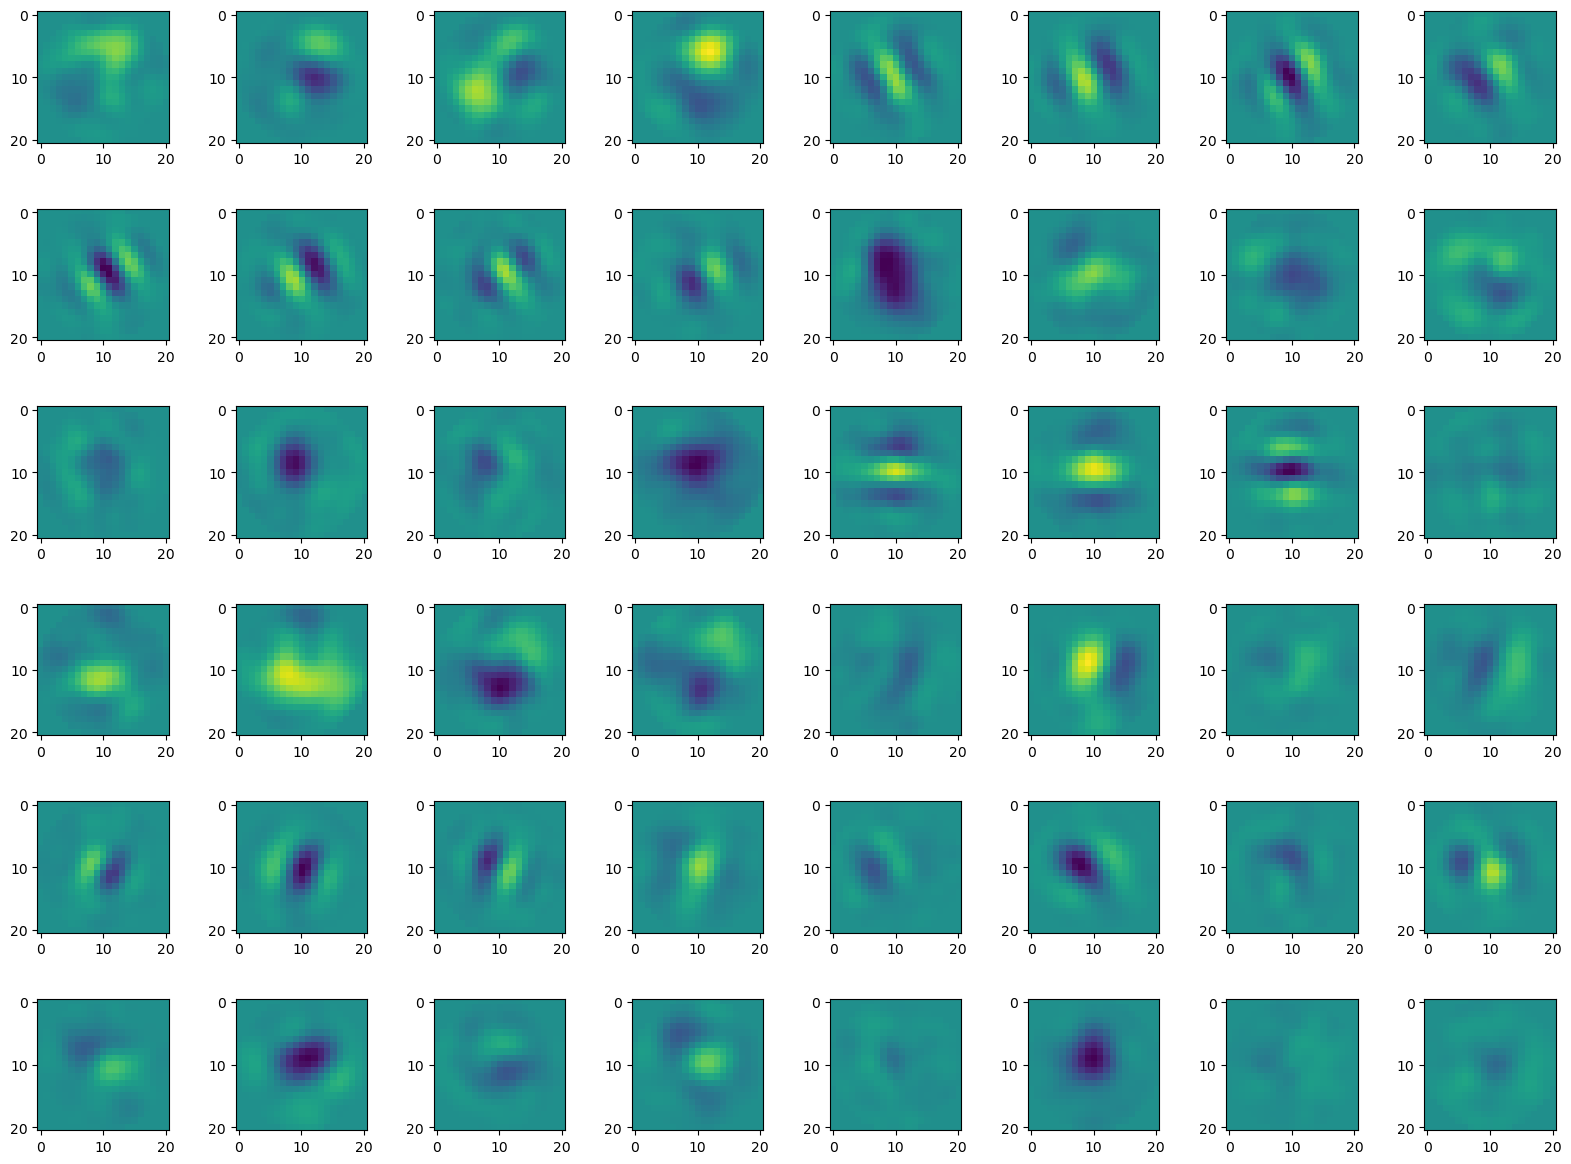

In [32]:
# XregP = 0.01
cnnRP2 = deepcopy(cnnR2)
print(np.mean(LLsR0), np.mean(LLsR1), np.mean(LLsR2))
ss(6,8,rh=2)
wP = cnnRP1.get_weights(layer_target=1)
for ii in range(12):
    for jj in range(4):
        plt.subplot(6,8,ii*4+jj+1)
        imagesc( wP[jj,:,:,ii], max=np.max(abs(wP[...,ii])) )
plt.show()

### Make rectified E/I version of same thing

In [33]:
nlags=10
XTreg = 0.0001
Mreg = 0.0001
Creg = None
#Dreg = 0.5
XregP = 0.01
angle_max = 180 
angle_inc = 30
angle_mode = 'nearest' 
pos_con_internal = True  # CHANGED
pos_con_out = True  # CHANGED

## CORE-SCAFFOLD
num_subs = [4, 12, 8]
fws = [9, 21, 5]  
angles = np.arange(0, angle_max, angle_inc).astype(int)

# LGN layer
clayersQ = [STconvLayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=num_subs[0], norm_type=1,
    filter_dims=[1,fws[0],fws[0],nlags] , bias=False, NLtype='relu',
    padding='circular', output_norm='batch', window='hamming', initialize_center=True,
    reg_vals={'d2xt':XTreg, 'center': Creg} )]

# PROJECTION LAYER
clayersQ.append(
    OriConvLayer.layer_dict(
        num_filters=num_subs[1], #num_inh=num_subs[1]//3,
        filter_width=fws[1], NLtype='relu', norm_type=1, pos_constraint=False,
        bias=False, output_norm='batch', window='hamming', padding='circular', initialize_center = True, 
        angles = angles, reg_vals={'d2x':XregP}) )

for ii in range(2,len(fws)):
    clayersQ.append(OriConvLayer.layer_dict( 
        num_filters=num_subs[ii], bias=False, norm_type=1, 
        filter_width=fws[ii], NLtype='relu', pos_constraints=pos_con_internal,
        output_norm='batch', initialize_center=True, #window='hamming', 
        angles=angles) )
        
scaffold_netQ =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold3d', xstim_n='stim', layer_list=clayersQ, scaffold_levels=[1,2], num_lags_out=len(angles))

readout_parsQ = ReadoutLayerQsample.layer_dict(
    num_filters=NCC, NLtype='softplus', bias=True, pos_constraint=pos_con_out)

readout_netQ = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0], layer_list = [readout_parsQ], ffnet_type='readout')

NQ = len(angles)
print(NQ, angles)

drift_pars = NDNLayer.layer_dict( 
    input_dims=[1,1,1,NA], num_filters=NCC, bias=False, norm_type=0, NLtype='lin')
drift_pars['reg_vals'] = {'d2t': Dreg } 

drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars] )

comb_layer = ChannelLayer.layer_dict(
    num_filters = NCC, NLtype='softplus', bias=True)
comb_layer['weights_initializer'] = 'ones'

comb_net = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[1,2],
    layer_list = [comb_layer], ffnet_type='add')


cnnR0R = NDN( 
    ffnet_list = [scaffold_netQ, readout_netQ, drift_net, comb_net], loss_type='poisson')
cnnR0R.block_sample = True

## Network 0
cnnR0R.networks[0].layers[0] = deepcopy(cnn0.networks[0].layers[0])
cnnR0R.networks[0].layers[0].set_parameters(val=False)

## Retwork 1: readout: fixed mus / sigmas
#cnn0.networks[1].layers[0].sample = False
cnnR0R.networks[1].layers[0].mu.data = torch.tensor( musC, dtype=torch.float32)
cnnR0R.networks[1].layers[0].Qmu.data[:,0] = torch.tensor( (thetasC-90)/90, dtype=torch.float32)
cnnR0R.networks[1].layers[0].fit_mus(False)
cnnR0R.networks[1].layers[0].fit_Qmus(False)
cnnR0R.networks[1].layers[0].Qsample_mode = angle_mode

## Network 2: drift: not fit
cnnR0R.networks[2].layers[0].weight.data = torch.tensor(drift_termsC, dtype=torch.float32)
cnnR0R.networks[2].set_parameters(val=False)

## Network 3: Comb
cnnR0R.networks[3].set_parameters(val=False, name='weight')

cnnR0R.fit(dataC, **adam_pars, verbose=2)
LLsR0R = LLsNULL - cnnR0R.eval_models(dataC, data_inds=dataC.val_blks, batch_size=5, device=device)
print(np.mean(LLsR0R))

cnnR1R = deepcopy(cnnR0R)
cnnR1R.networks[1].layers[0].fit_Qmus(True)
cnnR1R.networks[1].layers[0].Qsample_mode = 'bilinear'
cnnR1R.fit(dataC, **adam_parsC, verbose=2)
LLsR1R = LLsNULL - cnnR1R.eval_models(dataC, data_inds=dataC.val_blks, batch_size=8, device=device)
print(np.mean(LLsR0R), np.mean(LLsR1R))

cnnR2R = deepcopy(cnnR1R)
cnnR2R.networks[1].layers[0].Qsample_mode = 'nearest'
cnnR2R.fit(dataC, **adam_parsC, verbose=2)
LLsR2R = LLsNULL - cnnR2R.eval_models(dataC, data_inds=dataC.val_blks, batch_size=8, device=device)
print(np.mean(LLsR0R), np.mean(LLsR1R), np.mean(LLsR2R))

6 [  0  30  60  90 120 150]
  ReadoutLayer: not fitting mus
  ReadoutLayer: not fitting Qmus
Model: M102_CsXX_X_N_A

GPU Available: True, GPU Used: True


Validating ver=79: 100%|█████████████████| 34/34 [00:14<00:00,  2.33it/s, val_loss=0.106508]


Early stopping
Done fitting
  Fit complete: 1524.241533756256 sec elapsed


Eval models: 100%|██████████████████████████████████████████| 80/80 [00:14<00:00,  5.44it/s]


0.032075416223675594
  ReadoutLayer: fitting Qmus
Model: M102_CsXX_X_N_A

GPU Available: True, GPU Used: True


Validating ver=80: 100%|█████████████████| 34/34 [00:14<00:00,  2.30it/s, val_loss=0.105811]


Early stopping
Done fitting
  Fit complete: 2442.898354291916 sec elapsed


Eval models: 100%|██████████████████████████████████████████| 50/50 [00:14<00:00,  3.41it/s]


0.032075416223675594 0.041623361554800294
Model: M102_CsXX_X_N_A

GPU Available: True, GPU Used: True


Validating ver=81: 100%|█████████████████| 34/34 [00:14<00:00,  2.30it/s, val_loss=0.107209]


Early stopping
Done fitting
  Fit complete: 2742.1269063949585 sec elapsed


Eval models: 100%|██████████████████████████████████████████| 50/50 [00:14<00:00,  3.43it/s]

0.032075416223675594 0.041623361554800294 0.0413582535351024


0.03626761103377623 0.04252116148378335 0.03904563509950451


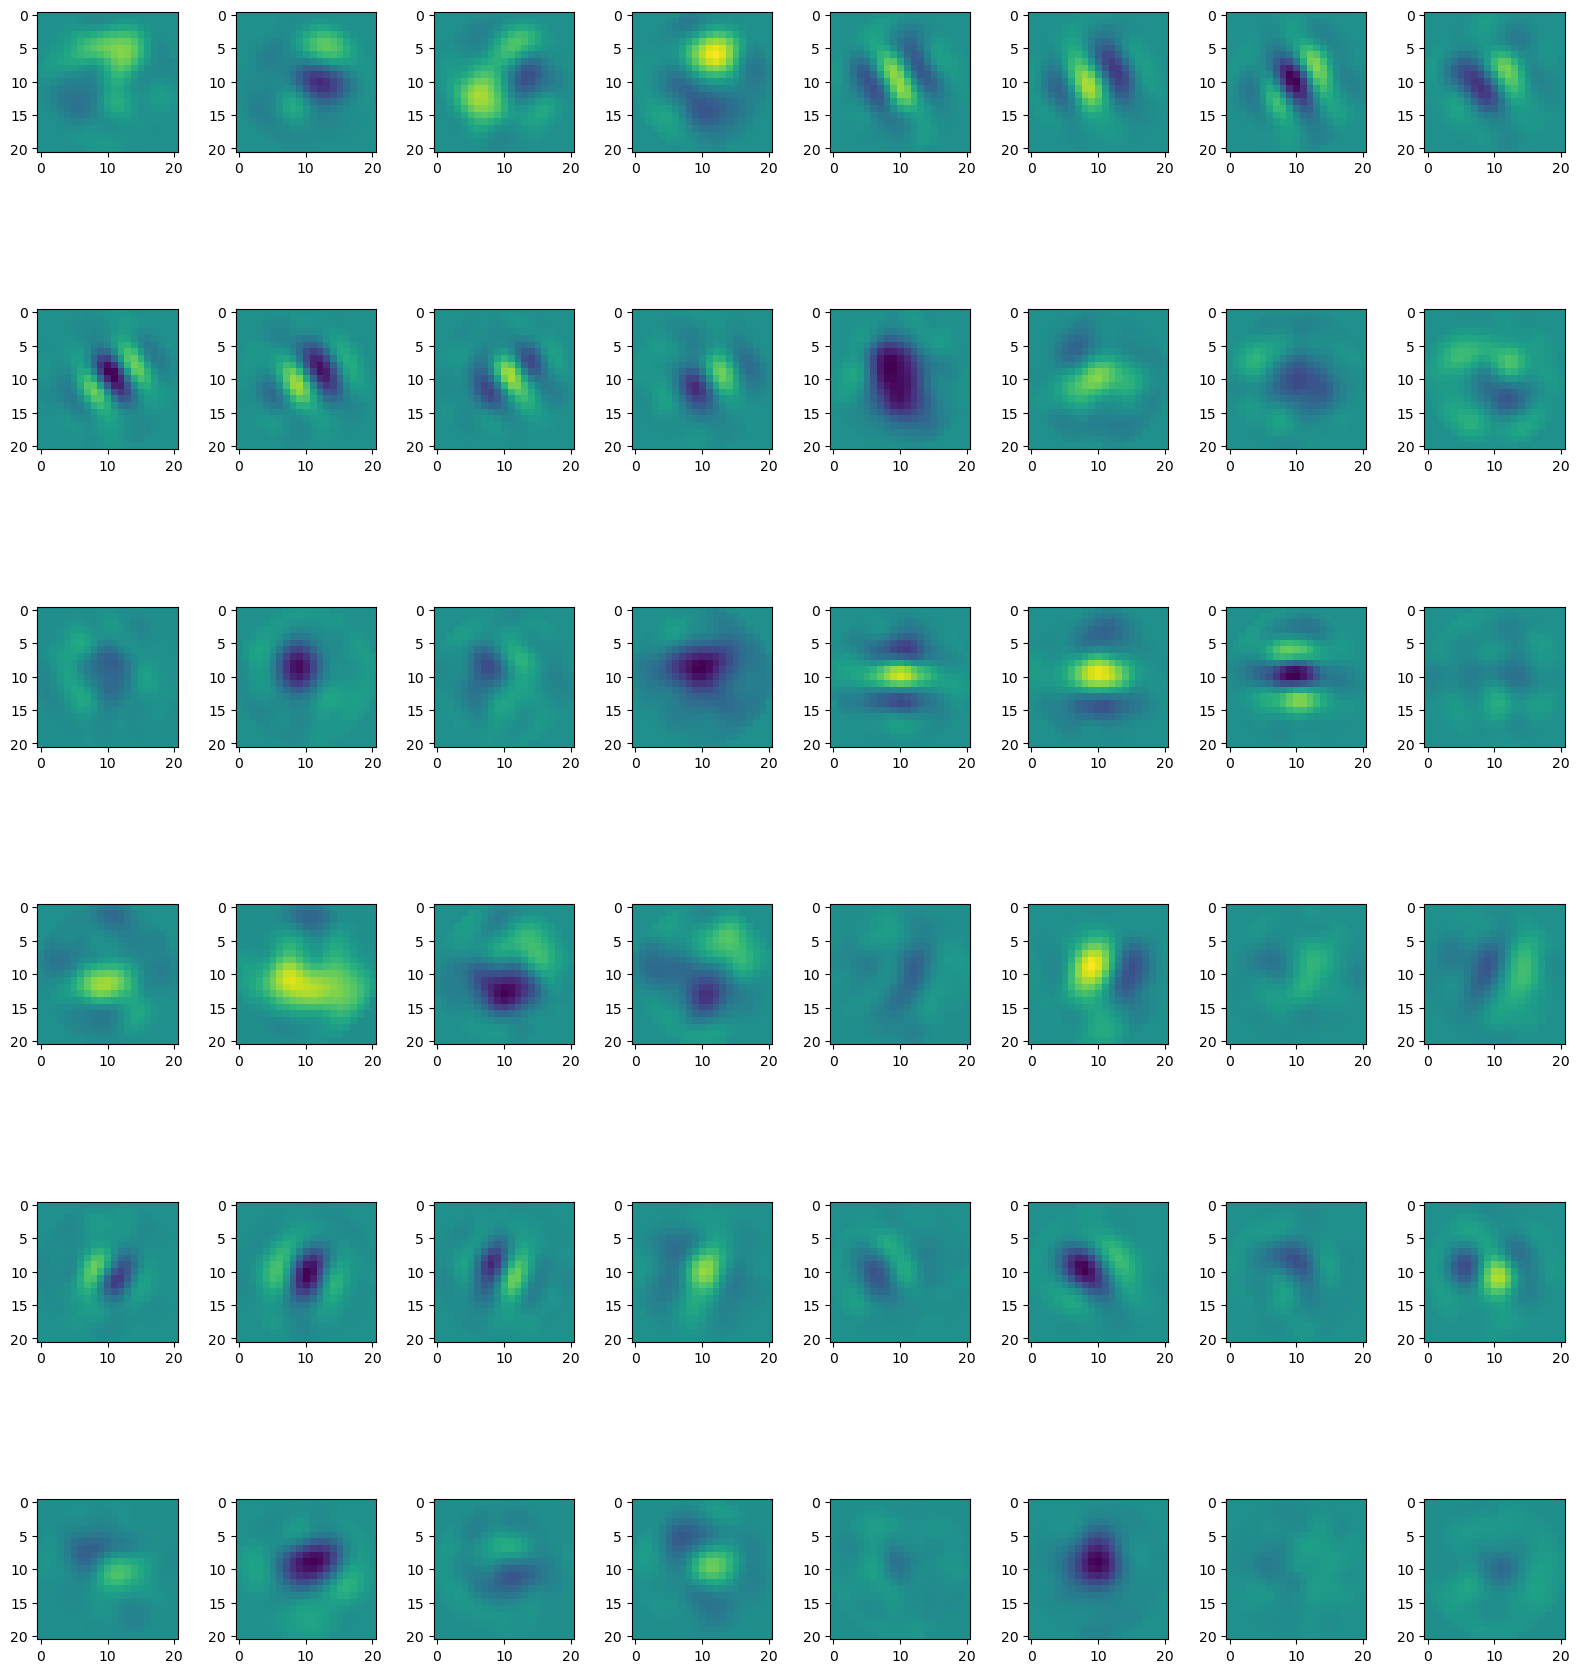

In [29]:
# XregP = 0.1
cnnRP1 = deepcopy(cnnR2)
print(np.mean(LLsR0), np.mean(LLsR1), np.mean(LLsR2))
ss(6,8)
wP = cnnRP1.get_weights(layer_target=1)
for ii in range(12):
    for jj in range(4):
        plt.subplot(6,8,ii*4+jj+1)
        imagesc( wP[jj,:,:,ii], max=np.max(abs(wP[...,ii])) )
plt.show()

0.037983692744198966 0.041199261943499245 0.04137473626464021


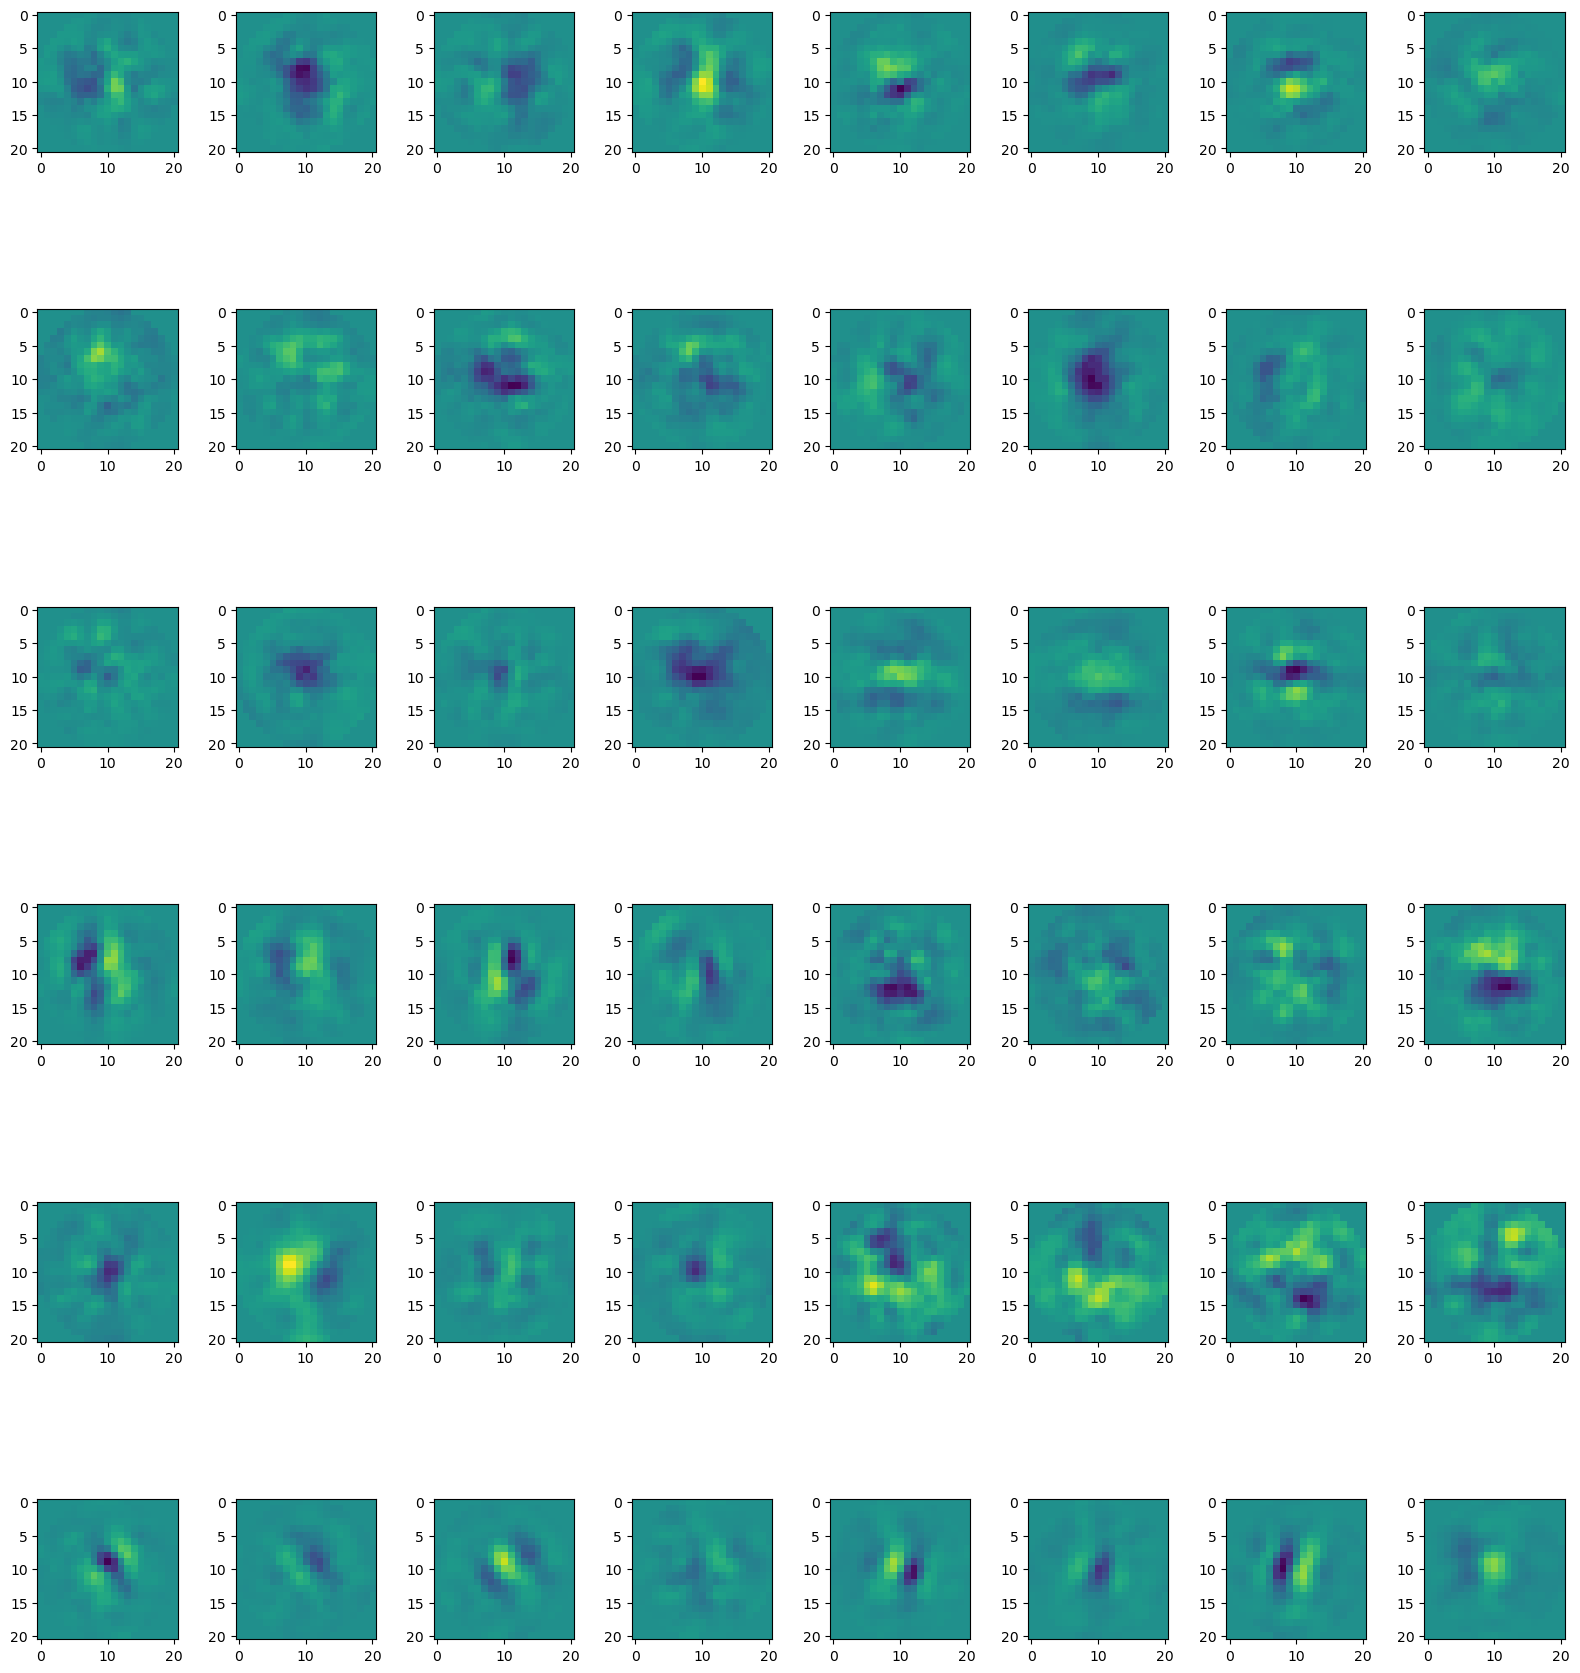

In [27]:
# XregP = 0.001
cnnRP3 = deepcopy(cnnR2)
print(np.mean(LLsR0), np.mean(LLsR1), np.mean(LLsR2))
ss(6,8)
wP = cnnR2.get_weights(layer_target=1)
for ii in range(12):
    for jj in range(4):
        plt.subplot(6,8,ii*4+jj+1)
        imagesc( wP[jj,:,:,ii], max=np.max(abs(wP[...,ii])) )
plt.show()

#### IDEA: MAKE ASYMMETRIC CONVOLUTIONAL LAYERS (LAYER) that favor horizontal connectivity/orientation. 
OR make spatial H x V (low D) to force along x and y axis (and then its rotated?)

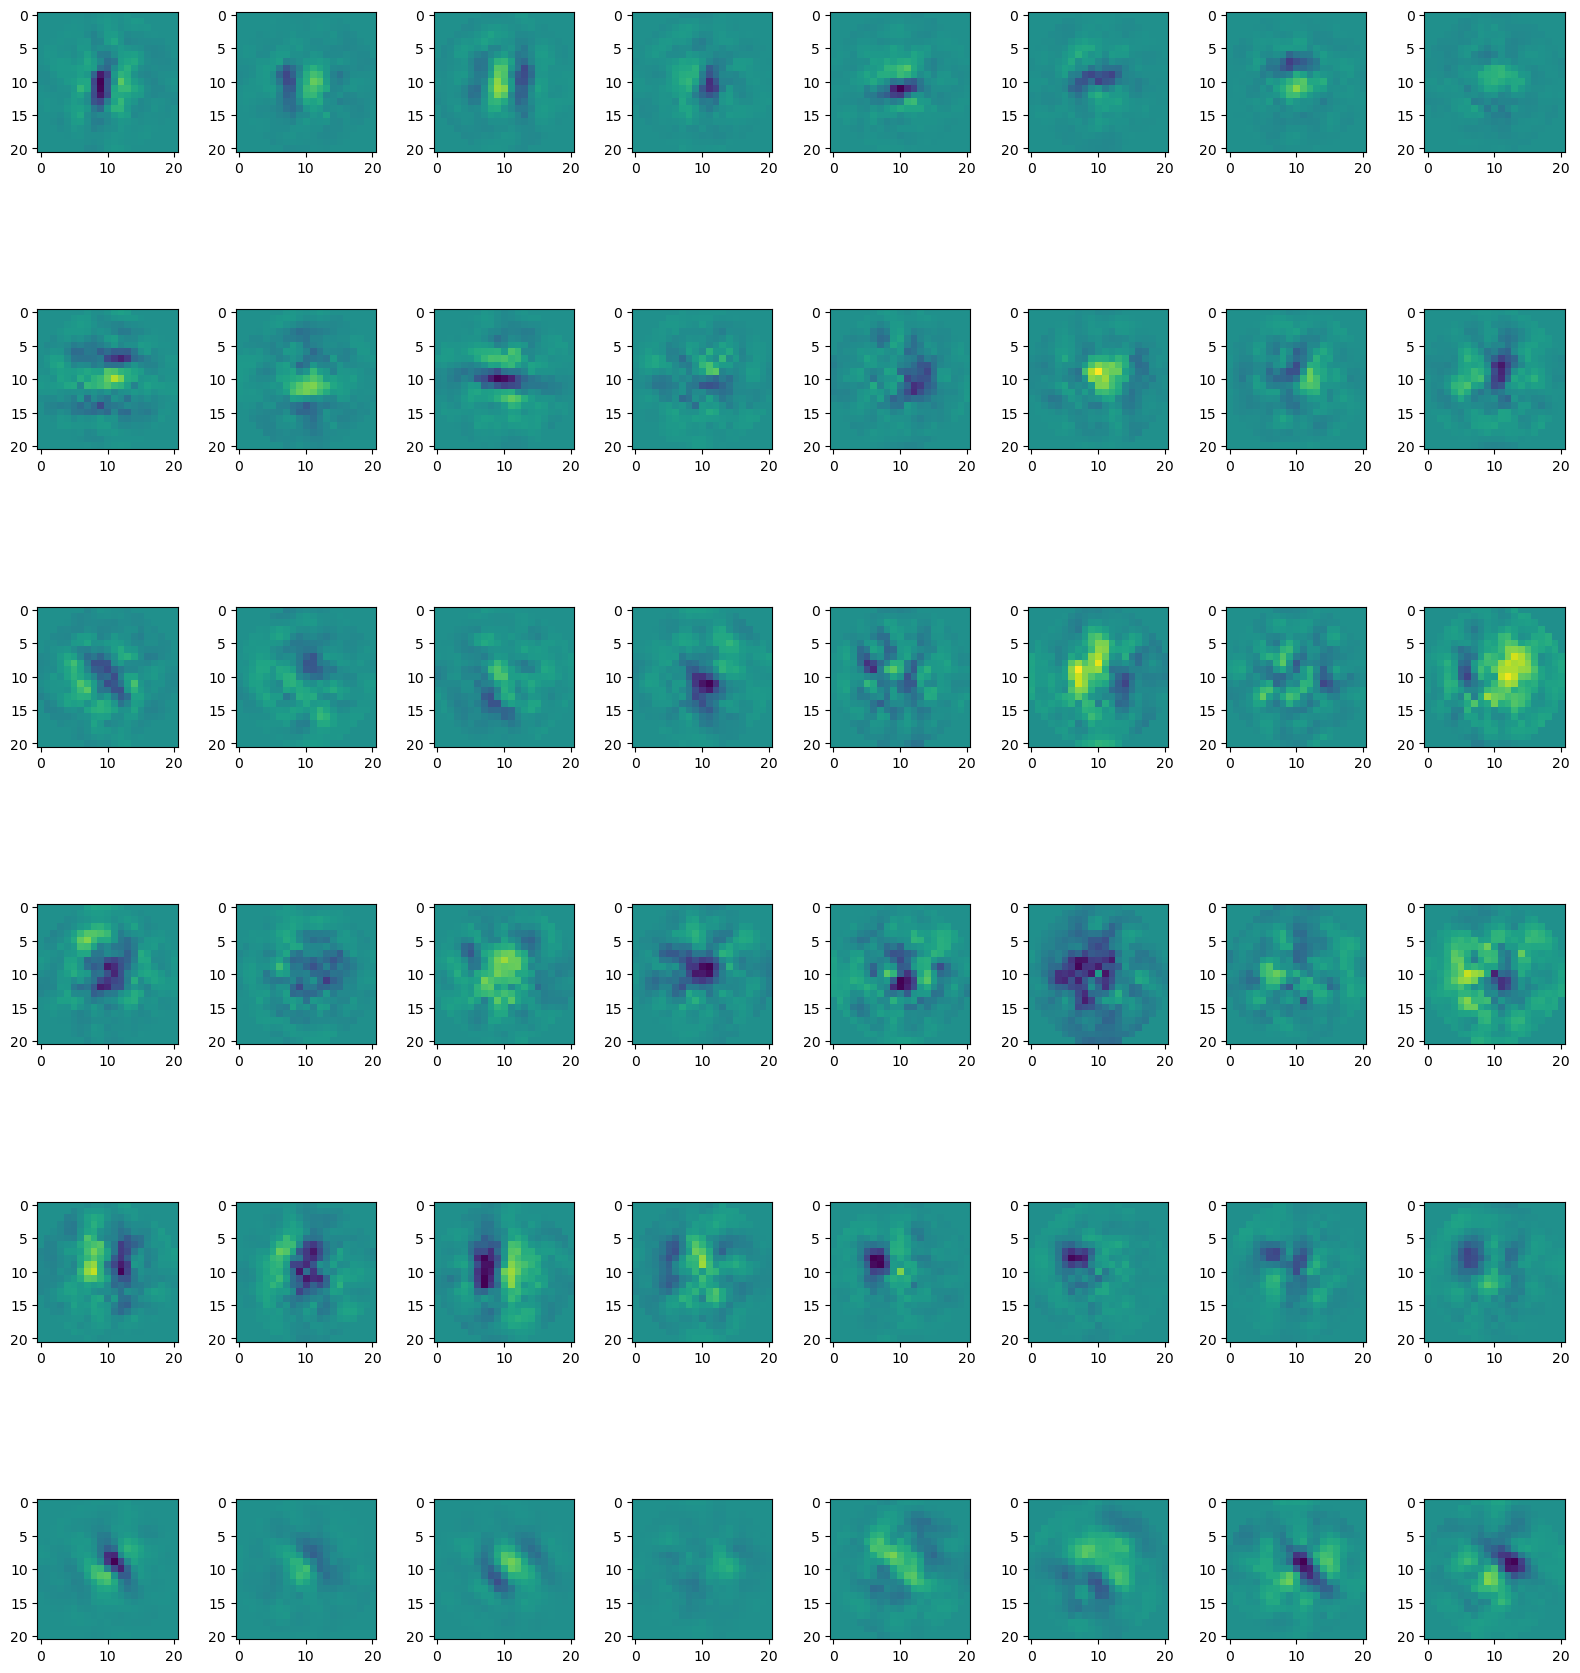

In [16]:
ss(6,8)
wP = cnnC1.get_weights(layer_target=1)
for ii in range(12):
    for jj in range(4):
        plt.subplot(6,8,ii*4+jj+1)
        imagesc( wP[jj,:,:,ii], max=np.max(abs(wP[...,ii])) )
plt.show()

In [17]:
cnnL4 = deepcopy(cnnC1)
LLsL4 = deepcopy(LLsC1)
print(np.mean(LLsC1))

0.04176034734529607


In [ ]:
### CHECK THAT REDUCING MUS TO AVERAGE DOESN't change

In [29]:
Bcnn0 = deepcopy(cnnC0)  # 1/2.5 shorter than normal: 12x2 (?? epocs/)
BLLs0 = deepcopy(LLsC0)
print(np.mean(BLLs0))

0.03097615814676472


In [32]:
Bcnn1 = deepcopy(cnnC0)  # 4x longer than 12x20 (17 epocks, 5427 sec)  # seed = 100
BLLs1 = deepcopy(LLsC0)
print(np.mean(BLLs1))

0.031070874602186913


In [36]:
Bcnn2 = deepcopy(cnnC0)  # middle : 12x5 (17 epocs/5428) -- seed 100 (wow same as above)
BLLs2 = deepcopy(LLsC0)
print(np.mean(BLLs2))

0.030470823540407067


In [39]:
Bcnn3 = deepcopy(cnnC0)  # 10x shorter than normal: 6x1 (?? epocs/)
BLLs3 = deepcopy(LLsC0)
print(np.mean(BLLs3))

0.02785473302298901


In [42]:
Bcnn4 = deepcopy(cnnC0)  # 6x longer than 12x30 (17 epocks, 5427 sec)  # seed = 100
BLLs4 = deepcopy(LLsC0)
print(np.mean(BLLs4))

0.03101861360026341


In [ ]:
## Third alternative: fit for a couple epochs without fitting mus/Qmus and then switch 

In [ ]:
### CHECK BATCH SIZE, WEIGHT DECAY -- 2 different strats

In [15]:
cnnC1 = deepcopy(cnnC0)
cnnC1.networks[1].layers[0].fit_Qmus(True)
cnnC1.list_parameters()
cnnC1.fit(dataC, **adam_pars, verbose=2)
LLsC1 = LLsNULL - cnnC1.eval_models(dataC, data_inds=dataC.val_blks, batch_size=8, device=device)
print(np.mean(LLsC0), np.mean(LLsC1))

  ReadoutLayer: fitting Qmus
Network 0:
  Layer 0:
      NOT FIT: weight: torch.Size([810, 4])
  Layer 1:
      weight: torch.Size([1764, 12])
  Layer 2:
      weight: torch.Size([588, 8])
Network 1:
  Layer 0:
      weight: torch.Size([20, 102])
      bias: torch.Size([102])
      NOT FIT: mu: torch.Size([102, 2])
      NOT FIT: sigma: torch.Size([102, 1])
      Qmu: torch.Size([102, 1])
      Qsigma: torch.Size([102, 1])
Network 2:
  Layer 0:
      NOT FIT: weight: torch.Size([158, 102])
Network 3:
  Layer 0:
      NOT FIT: weight: torch.Size([1, 102])
      bias: torch.Size([102])
Model: M102_CsXX_X_N_A

GPU Available: True, GPU Used: True


Validating ver=20: 100%|█████████████████| 34/34 [00:31<00:00,  1.08it/s, val_loss=0.107045]


Early stopping
Done fitting
  Fit complete: 2950.0402567386627 sec elapsed


Eval models: 100%|██████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s]

0.032589717822916364 0.02333290553560444


[101]